### Load Dataset

### Read data

In [1]:
import numpy as np
import pandas as pd

In [2]:
!ls /kaggle/input/shakespeare-plays

Shakespeare_data.csv  alllines.txt  william-shakespeare-black-silhouette.jpg


In [3]:
df = pd.read_csv('/kaggle/input/shakespeare-plays/Shakespeare_data.csv')
df = df.dropna() # drop lines which doesn't correspond to player, lines like "ACT I"
df = df.reset_index()

# group player phrases into one big sentence

def concat(group):
    return ' '.join(group['PlayerLine'].tolist())

df = df.groupby(['PlayerLinenumber', 'Player']).apply(concat).reset_index()
df['Text'] = df[0]
df = df.drop(columns=[0])

df['TextLen'] = df['Text'].apply(lambda x: len(x))

In [4]:
df.head()

,PlayerLinenumber,Player,Text,TextLen
0,1.0,AARON,"Now climbeth Tamora Olympus' top, Safe out of ...",1389
1,1.0,ACHILLES,I'll heat his blood with Greekish wine to-nigh...,469
2,1.0,ADAM,"Dear master, I can go no further. O, I die for...",118
3,1.0,ADRIANA,"Neither my husband nor the slave return'd, Tha...",372
4,1.0,ADRIANO DE ARMADO,"Boy, what sign is it when a man of great spiri...",117


In [5]:
df.shape

(20669, 4)

In [6]:
df.Text[0]

"Now climbeth Tamora Olympus' top, Safe out of fortune's shot, and sits aloft, Secure of thunder's crack or lightning flash, Advanced above pale envy's threatening reach. As when the golden sun salutes the morn, And, having gilt the ocean with his beams, Gallops the zodiac in his glistering coach, And overlooks the highest-peering hills, So Tamora: Upon her wit doth earthly honour wait, And virtue stoops and trembles at her frown. Then, Aaron, arm thy heart, and fit thy thoughts, To mount aloft with thy imperial mistress, And mount her pitch, whom thou in triumph long Hast prisoner held, fetter'd in amorous chains And faster bound to Aaron's charming eyes Than is Prometheus tied to Caucasus. Away with slavish weeds and servile thoughts! I will be bright, and shine in pearl and gold, To wait upon this new-made empress. To wait, said I? to wanton with this queen, This goddess, this Semiramis, this nymph, This siren, that will charm Rome's Saturnine, And see his shipwreck and his commonwe

array([[<Axes: title={'center': 'TextLen'}>]], dtype=object)

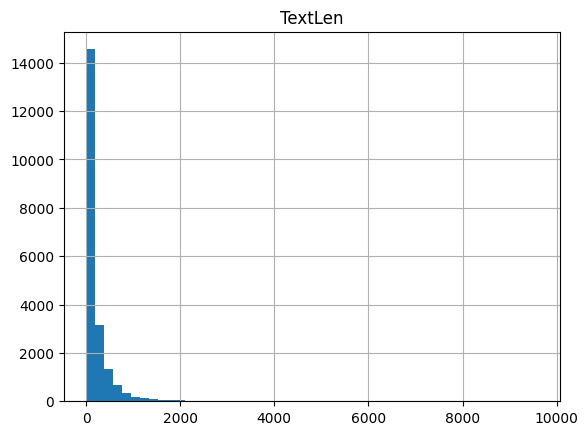

In [7]:
df.hist('TextLen', bins=50)

array([[<Axes: title={'center': 'TextLen'}>]], dtype=object)

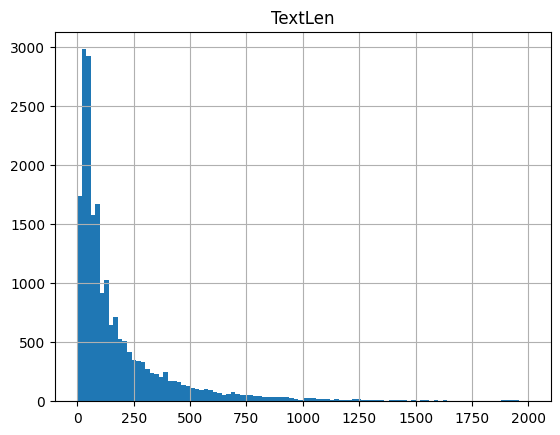

In [8]:
df.hist('TextLen', bins=100, range=(0, 2000))

We can notice here a long tail in the TextLen distribution.

In [9]:
df['TextLen'].mean()

202.41477575112486

In [10]:
df['Text'][2318]

"Saving your merry humour, here's the note How much your chain weighs to the utmost carat, The fineness of the gold and chargeful fashion. Which doth amount to three odd ducats more Than I stand debted to this gentleman: I pray you, see him presently discharged, For he is bound to sea and stays but for it. ANTIPHOLUS See that Claudio Be executed by nine to-morrow morning: Bring him his confessor, let him be prepared, For that's the utmost of his pilgrimage. Go to, let that be mine: Do you your office, or give up your place, And you shall well be spared. Yet may he live awhile, and, it may be,"

In [11]:
print(f'df.shape = {df.shape}')

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

print(f'train_df.shape = {train_df.shape}')
print(f'val_df.shape = {val_df.shape}')

train_df.to_csv('train_df.csv', index=None)
val_df.to_csv('val_df.csv', index=None)

df.shape = (20669, 4)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


train_df.shape = (17568, 4)
val_df.shape = (3101, 4)


### Transformers + Torch baseline with metrics

In [12]:
!pip install transformers[torch] accelerate

Imports

In [13]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
import torch.optim as optim
import math
import wandb

In [27]:
# Initialize wandb with your project and experiment name
wandb.init(project="shakespeare-transformers", name="gpt2-with-scheduler-adamw")

# Define the wandb config to log hyperparameters
wandb.config.learning_rate = 5e-5
wandb.config.num_epochs = 1
wandb.config.batch_size = 8
wandb.config.max_seq_len = 300

# Load the pre-trained GPT-2 model and tokenizer
model_name = "gpt2"  # Choose an appropriate model size
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

In [28]:
from torch.utils.data import Dataset
from tqdm.auto import tqdm

class ShakespeareDataset(Dataset):
    
    def __init__(self, df_path, tokenizer):
        tokenizer.pad_token = tokenizer.eos_token
        self.tokenized_text = []
        self.df = pd.read_csv(df_path)
        for ind, data in tqdm(self.df.iterrows(), total=self.df.shape[0], desc=f'Tokenizing {df_path}'):
            encoded = tokenizer.encode(data['Text'], max_length=wandb.config.max_seq_len, padding='max_length', truncation=True)
            self.tokenized_text.append(torch.tensor(encoded))
            
    def __len__(self):
        return len(self.tokenized_text)
    
    def __getitem__(self, index):
        return self.tokenized_text[index]

In [21]:
train_dataset = ShakespeareDataset('train_df.csv', tokenizer=tokenizer)
val_dataset = ShakespeareDataset('val_df.csv', tokenizer=tokenizer)

Tokenizing train_df.csv:   0%|          | 0/17568 [00:00<?, ?it/s]

Tokenizing val_df.csv:   0%|          | 0/3101 [00:00<?, ?it/s]

In [22]:
set([train_dataset[i].shape for i in range(10009)])

{torch.Size([300])}

In [23]:
pad_token_id = tokenizer.encode([tokenizer.pad_token])[0]

In [29]:
# Define training hyperparameters
# learning_rate = 1e-5
# num_epochs = 1
# batch_size = 4
# max_seq_len = 128
learning_rate = wandb.config.learning_rate
num_epochs = wandb.config.num_epochs
batch_size = wandb.config.batch_size

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=200,
    num_training_steps=-1,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss_sum = 0
    for idx, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}'):
        batch = batch.to(device)
        outputs = model(batch, labels=batch)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        train_loss_sum += loss.item()
        
        if idx % 500 == 499:
            print(train_loss_sum / idx)
    
    train_loss = train_loss_sum / len(train_loader)
    train_perplexity = np.exp(train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {train_loss:.4f} - Perplexity: {train_perplexity:.4f}")
    
    # Validation
    model.eval()
    val_loss_sum = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, total=len(val_loader), desc=f'Evaluation after epoch {epoch + 1}'):
            batch = batch.to(device)
            outputs = model(batch, labels=batch)

            loss = outputs.loss
            val_loss_sum += loss.item()
    
    val_loss = val_loss_sum / len(val_loader)
    val_perplexity = np.exp(val_loss)

    full_metrics_dict = {
        'train_loss': train_loss,
        'train_perplexity': train_perplexity,
        'val_loss': val_loss,
        'val_perplexity': val_perplexity,
    }
    print(f"Epoch [{epoch + 1}/{num_epochs}] - {full_metrics_dict}")
    wandb.log(full_metrics_dict)

# Optionally, save the trained model
model.save_pretrained("./shakespeare_finetuned")

# # Finish the wandb run
wandb.finish()

Epoch 1:   0%|          | 0/2196 [00:00<?, ?it/s]

1.3433302136246332
1.2004215877066862
1.1412198421973399
1.1199270073043042
Epoch [1/1] - Training Loss: 1.1098 - Perplexity: 3.0338


Evaluation after epoch 1:   0%|          | 0/388 [00:00<?, ?it/s]

Epoch [1/1] - {'train_loss': 1.1098246806401264, 'train_perplexity': 3.033826459294963, 'val_loss': 1.0202441342251818, 'val_perplexity': 2.7738718783693135}


train_loss,▁
train_perplexity,▁
val_loss,▁
val_perplexity,▁
train_loss,1.10982
train_perplexity,3.03383
val_loss,1.02024
val_perplexity,2.77387


In [ ]:
model.push_to_hub("gpt_2_shakespeare_finetuned", use_auth_token="...")
tokenizer.push_to_hub("gpt_2_shakespeare_finetuned", use_auth_token="...")

In [30]:
# Move the model to CUDA (GPU) if available


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

from transformers import pipeline, set_seed
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=device)
set_seed(42)
generator("To be or no to be", max_length=100, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "To be or no to be none to be that is as the royal son to thou do in, e' and not, let no the son: let be the lord. and for? what is thou must be not in the most of the king king must of the lord be king'd to no king from no hand and the king. So. now like O? he will must I to be the sword. be in for the soul from. I and the like from like a. And all"},
 {'generated_text': "To be or no to be the man. And not the king: if him. if he will be dead, and for more of the head then, for their air: and be nothing'! then to say? But in his lord now-! and that no of royal king, then in like now to the king and thou may' good as he will, not if from to all, thou will not to now to good brow, to his arm'd, no thou now as no more"},
 {'generated_text': "To be or no to be guilty to the good king, I'll, not we to say at and good as are good king: and to the dead man hath not as not the king of all. So for they had to be done, but the king, he is the prince of it of, he sent, they a

In [31]:
generator("The weather today is fine, so I have to", max_length=120, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "The weather today is fine, so I have to the'd, I have all. and we must, to thee hath lost none: if now? from the first the enemy in the enemy must be dead, he is, of thee, To the good: what is matter on for the true, he'll no to die the thou' not king's, no to and I was dead, and we be, I' you, is not and good, like? he not there the dead, we he. they'd for if? you the to as it do in the good and he,"},
 {'generated_text': "The weather today is fine, so I have to good, man in the royal, and they is not now enough the place, then we do to good, sir, I! the earth. and was the air then we must be: like a good lords of ten a son good and be now, nor: none like for the heart of in? And it be' and thou. the queen's good king he now of ', of not done, not and make of in haste! of good like the king? no ': I like for in whole now?' and love. of"},
 {'generated_text': "The weather today is fine, so I have to be dead, thou? we'll not no man, that is dead. 'tw'd and thou are:

In [32]:
def generate(model,
             tokenizer,
             prompt,
             entry_count=1,
             entry_length=64, #maximum number of words
             top_p=0.8,
             temperature=0.2,
):
    model.eval()
    generated_texts = []
    with torch.no_grad():
        for entry_idx in range(entry_count):
            generated_tokens = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
            generated_text = torch.tensor([]).unsqueeze(0)
            ended = False
            
            for _ in range(entry_length):
                outputs = model(generated_tokens)
                logits = outputs[0][:, -1, :]
                probs = torch.softmax(logits / (temperature if temperature > 0 else 1.0), dim=-1).squeeze()
                
                sorted_prob, sorted_indices = torch.sort(probs, descending=True)
                cumulative_prob = torch.cumsum(sorted_prob, dim=-1)
                top_p_indices = cumulative_prob > top_p
                
                top_p_indices[1:] = top_p_indices[:-1].clone()
                top_p_indices[0] = 0
                top_p_indices = sorted_indices[~top_p_indices]
                probs[top_p_indices] = 0
                probs /= torch.sum(probs)

                next_token_id = torch.multinomial(probs, 1)
                generated_tokens = torch.cat((generated_tokens, next_token_id.unsqueeze(-1)), dim=-1)
                generated_text = torch.cat((generated_text, next_token_id.unsqueeze(-1)), dim=-1)

                if next_token_id[0] is tokenizer.eos_token_id:
                    output_list = list(generated_text.squeeze().numpy())
                    output_text = tokenizer.decode(output_list)
                    generated_texts.append(output_text)
                    ended = True
                    break
            
            if not ended:
                output_list = list(generated_text.squeeze().numpy())
                generated_texts.append(prompt + tokenizer.decode(output_list))
                
    return generated_texts

In [37]:
prompt = 'The King'

generate(model.to('cpu'), tokenizer, prompt, entry_count=2, entry_length=400//4)

['The King, he was gone, I am no more to be no man to be? he hath the whole power, I am no. I have done, I shall not to be of good lord of good lord of his own, he hath the whole and be to all for and I will, he to be to and be of a thousand. I have, he hath gone. I have done, the good and I have done, he will, I. and I, he hath gone. I be',
 'The King is no more of king to the head, nor to be to be to be gone. But the whole world is, if the whole king and be the head, he hath gone. he will not. I to be in a thousand and I a whole and he must not. and I have gone. I have done to be of a good man to be no good and he will the head and and I shall to be all of he, he hath gone. I to be dead. I,']

In [38]:
len('The King is no more of king to the head, nor to be to be to be gone. But the whole world is, if the whole king and be the head, he hath gone. he will not. I to be in a thousand and I a whole and he must not. and I have gone. I have done to be of a good man to be no good and he will the head and and I shall to be all of he, he hath gone. I to be dead. I')

354